# 3D point cloud object segmentation based on sensor fusion and 2D mask guidance

### Introduction

In [1]:
# import necessary libraries
import supervisely as sly
from dotenv import load_dotenv
from PIL import Image
import os
import matplotlib.pyplot as plt
import open3d as o3d
from functions import *
from supervisely.project.project_type import ProjectType
from supervisely.geometry.pointcloud import Pointcloud
from supervisely.pointcloud_annotation.pointcloud_tag_collection import (
    PointcloudTagCollection,
)
from supervisely.pointcloud_annotation.pointcloud_object_collection import (
    PointcloudObjectCollection,
)


# load credentials
load_dotenv("../supervisely.env")
api = sly.Api()

# set image display parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Download photo context and visualize mask annotations

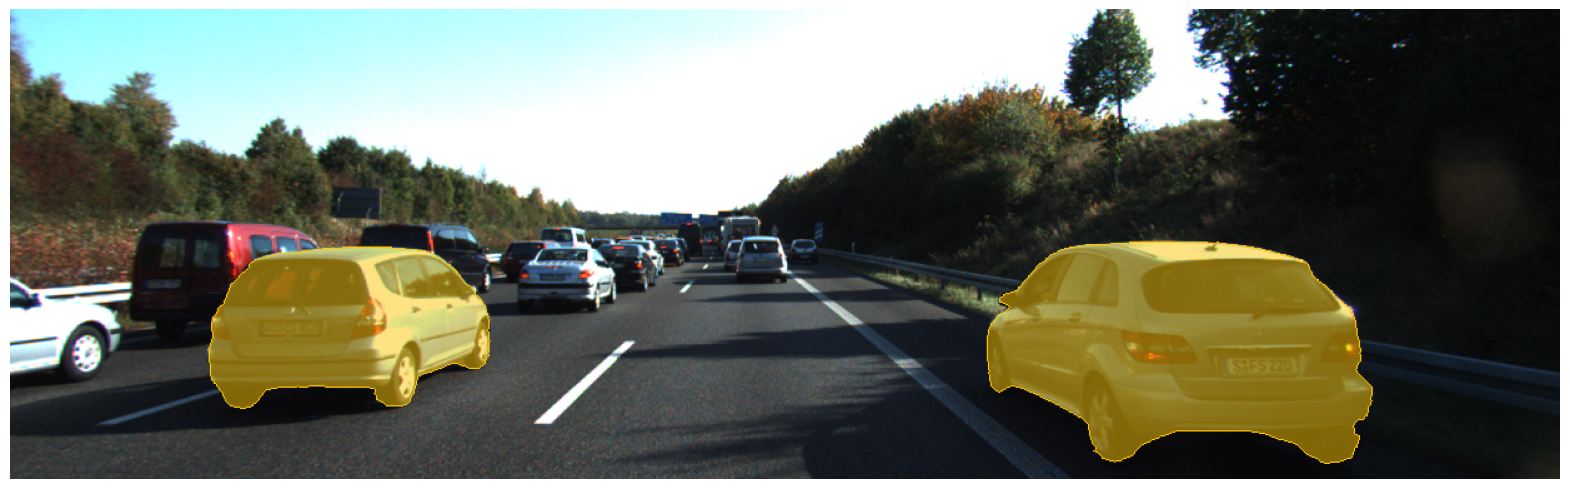

In [2]:
# define project id and photo context image id
photo_context_project_id = 43714
photo_context_image_id = 32382786

# download photo context image
photo_context_image_np = api.image.download_np(photo_context_image_id)
masked_photo_context_image_np = photo_context_image_np.copy()

# download photo context image annotation
project_meta_json = api.project.get_meta(photo_context_project_id)
project_meta = sly.ProjectMeta.from_json(project_meta_json)
ann_json = api.annotation.download(photo_context_image_id).annotation
ann = sly.Annotation.from_json(ann_json, project_meta)

# draw annotation on photo context image
ann.draw_pretty(masked_photo_context_image_np, thickness=1)

# create output directory
save_dir = "../tutorial_data/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# save result
masked_photo_context_path = os.path.join(save_dir, "masked_photo_context.png")
masked_photo_context_image = Image.fromarray(masked_photo_context_image_np)
masked_photo_context_image.save(masked_photo_context_path)

# display result
plt.axis("off")
plt.imshow(masked_photo_context_image);

### Download input point cloud

In [ ]:
# define point cloud id and download it to local storage
pcd_id = 32384623
local_pcd_path = os.path.join(save_dir, "lidar_data.pcd")
api.pointcloud.download_path(pcd_id, local_pcd_path)

# display point cloud on interactive plot (renders only in nbviewer, not on github)
visualize_pcd(local_pcd_path)

### Get sensor calibration parameters

In [4]:
# define target camera number
camera_number = 2

# read calib_cam_to_cam.txt
calib_cam_to_cam_file = open("../tutorial_data/calib_cam_to_cam.txt")
calib_cam_to_cam_dict = {}
for line in calib_cam_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_cam_to_cam_dict[key] = value.strip()
calib_cam_to_cam_file.close()

# read calib_velo_to_cam.txt
calib_velo_to_cam_file = open("../tutorial_data/calib_velo_to_cam.txt")
calib_velo_to_cam_dict = {}
for line in calib_velo_to_cam_file.readlines():
    key, value = line.split(": ")
    calib_velo_to_cam_dict[key] = value.strip()
calib_velo_to_cam_file.close()

In [5]:
# get projection matrices
P_rect = calib_cam_to_cam_dict[f"P_rect_0{camera_number}"]
P_rect = np.array([float(x) for x in P_rect.split(" ")]).reshape(
    (3, 4)
)
P_rect

array([[ 7.188560e+02,  0.000000e+00,  6.071928e+02,  4.538225e+01],
       [ 0.000000e+00,  7.188560e+02,  1.852157e+02, -1.130887e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.779761e-03]])

In [6]:
# get rectified rotation matrices
R_rect = calib_cam_to_cam_dict[f"R_rect_0{camera_number}"]
R_rect = np.array([float(x) for x in R_rect.split(" ")]).reshape(
    (3, 3)
)
# add (0, 0, 0) translation and convert to homogeneous coordinates
R_rect = np.insert(R_rect, 3, values=[0, 0, 0], axis=0)
R_rect = np.insert(R_rect, 3, values=[0, 0, 0, 1], axis=1)
R_rect

array([[ 9.999191e-01,  1.228161e-02, -3.316013e-03,  0.000000e+00],
       [-1.228209e-02,  9.999246e-01, -1.245511e-04,  0.000000e+00],
       [ 3.314233e-03,  1.652686e-04,  9.999945e-01,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [7]:
# get rotation matrix from reference camera to target camera
R = calib_cam_to_cam_dict[f"R_0{camera_number}"]
R = np.array([float(x) for x in R.split(" ")]).reshape((3, 3))
# get translation vector from reference camera to target camera
t = calib_cam_to_cam_dict[f"T_0{camera_number}"]
t = np.array([float(x) for x in t.split(" ")]).reshape((3, 1))
# get reference camera to target camera rigid body transformation in homogeneous coordinates
T_ref_to_target = np.insert(np.hstack((R, t)), 3, values=[0, 0, 0, 1], axis=0)
T_ref_to_target

array([[ 9.999788e-01, -5.008404e-03, -4.151018e-03,  5.954406e-02],
       [ 4.990516e-03,  9.999783e-01, -4.308488e-03, -7.675338e-04],
       [ 4.172506e-03,  4.287682e-03,  9.999821e-01,  3.582565e-03],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

In [8]:
# get lidar to camera reference transformation
R_velo = np.array([float(x) for x in calib_velo_to_cam_dict["R"].split(" ")]).reshape((3, 3))
t_velo = np.array([float(x) for x in calib_velo_to_cam_dict["T"].split(" ")])[:, None]
T_velo_ref0 = np.vstack((np.hstack((R_velo, t_velo)), np.array([0, 0, 0, 1])))
T_velo_ref0

array([[ 7.967514e-03, -9.999679e-01, -8.462264e-04, -1.377769e-02],
       [-2.771053e-03,  8.241710e-04, -9.999958e-01, -5.542117e-02],
       [ 9.999644e-01,  7.969825e-03, -2.764397e-03, -2.918589e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

### Project LiDAR 3D points on 2D photo context image

In [9]:
# transform from velo (LiDAR) to target camera
T_velo_to_cam = P_rect @ R_rect @ T_ref_to_target @ T_velo_ref0
T_velo_to_cam

array([[ 6.07484390e+02, -7.18537361e+02, -1.01875822e+01,
        -9.55729189e+01],
       [ 1.80027463e+02,  5.89922104e+00, -7.20148711e+02,
        -9.34570810e+01],
       [ 9.99973895e-01,  4.85949260e-04, -7.20693419e-03,
        -2.84637351e-01]])

In [10]:
# get lidar points
pcd = o3d.io.read_point_cloud(local_pcd_path, format="pcd")
pcd_points = np.asarray(pcd.points)
xyzw = np.insert(pcd_points, 3, 1, axis=1).T
xyzw

array([[70.12200165, 69.74500275, 68.9509964 , ...,  3.76300001,
         3.7809999 ,  3.77699995],
       [37.46500015, 37.54600143, 37.39799881, ..., -1.42400002,
        -1.41700006, -1.40900004],
       [ 2.89700007,  2.88800001,  2.86199999, ..., -1.75999999,
        -1.76699996, -1.76400006],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [11]:
# get 3D points projections on photo context image
projections = T_velo_to_cam @ xyzw
projections[:2] /= projections[2, :]
projections

array([[222.71653185, 219.79103526, 216.86000628, ..., 925.86836546,
        922.80742564, 921.52290694],
       [152.7242648 , 152.67601167, 152.61939769, ..., 528.05500769,
        527.71001796, 527.50650563],
       [ 69.83286137,  69.45597654,  68.66210638, ...,   3.49025664,
          3.50830991,   3.50429233]])

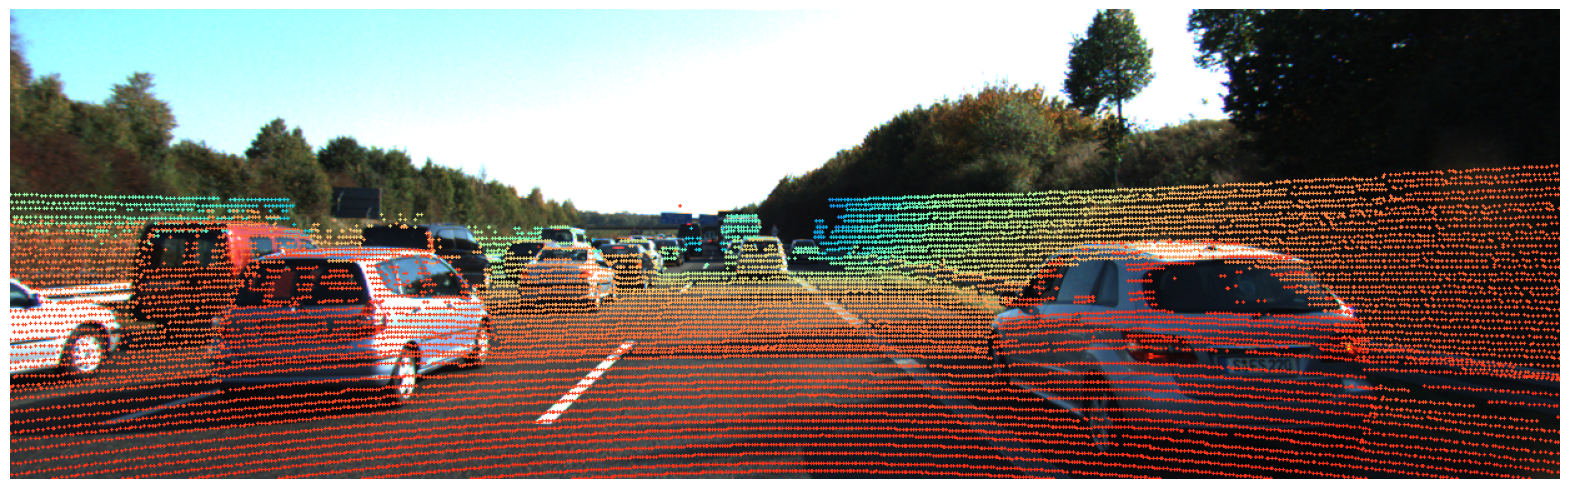

In [12]:
# draw point projections on image and display result
save_path = os.path.join(save_dir, "projections.png")
draw_projections_on_image(projections.copy(), photo_context_image_np.copy(), save_path)
plt.axis("off")
plt.imshow(Image.open(save_path));

### Get LiDAR point projections located inside masks on photo context image

In [13]:
# download photo context image annotation
project_meta_json = api.project.get_meta(photo_context_project_id)
project_meta = sly.ProjectMeta.from_json(project_meta_json)
ann_json = api.annotation.download(photo_context_image_id).annotation
ann = sly.Annotation.from_json(ann_json, project_meta)

# get binary masks
labels = ann.labels
bitmap = np.zeros(photo_context_image_np.shape, dtype=np.uint8)
for label in labels:
    geometry = label.geometry
    geometry.draw(bitmap=bitmap, color=[1, 1, 1])
bitmap = bitmap[:, :, :2]  # to 2d

# get indexes of projections which are located inside masks
u, v, z = projections
inside_masks = []
img_h, img_w, _ = photo_context_image_np.shape
for idx in range(len(pcd.points)):
    point = np.array([int(u[idx]), int(v[idx])])
    if (point[0] <= 0 or point[0] >= img_w) or (point[1] <= 0 or point[1] >= img_h):
        continue
    else:
        if np.all(bitmap[point[1], point[0]] == 1):
            inside_masks.append(idx)

print(f"{len(inside_masks)} point projections are located inside masks")

3949 point projections are located inside masks


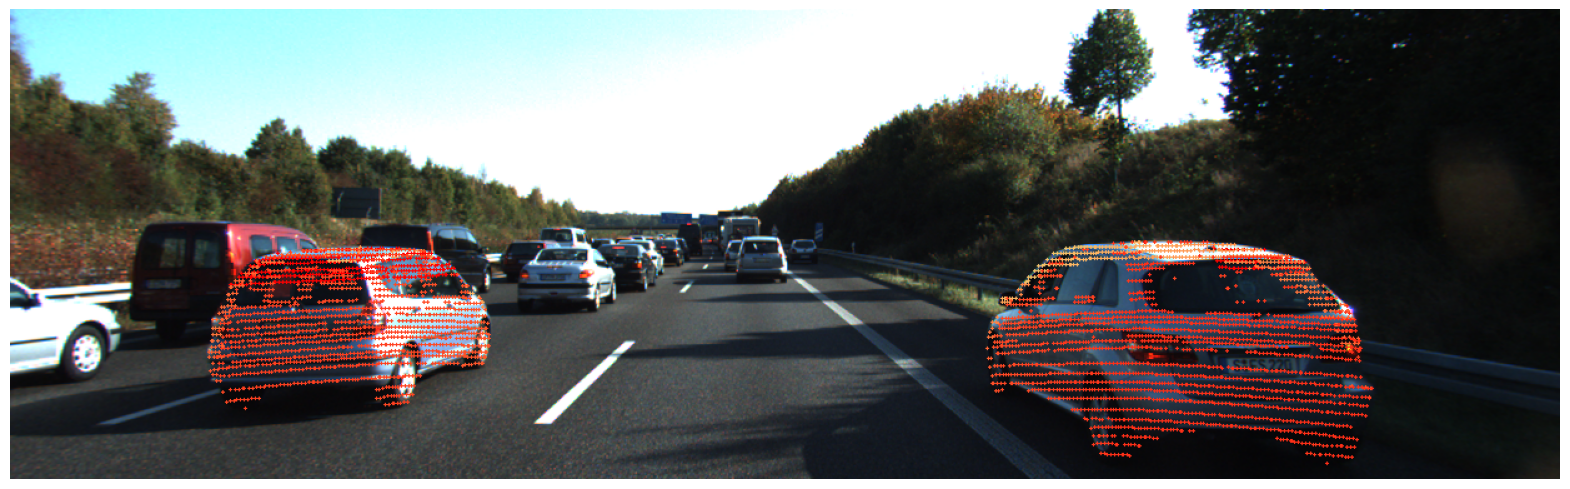

In [14]:
# display point projections located inside masks
masked_projections_save_path = os.path.join(save_dir, "masked_projections.png")
draw_projections_on_image(
    projections.copy(),
    photo_context_image_np.copy(),
    masked_projections_save_path,
    preprocess=False,
    indexes=inside_masks,
)
plt.axis("off")
plt.imshow(Image.open(masked_projections_save_path));

### Create 3D point cloud segmentation masks

In [ ]:
# transfer segmentation masks from 2D to 3D and display result (renders only in nbviewer, not on github)
visualize_3d_masks(local_pcd_path, inside_masks)

In [16]:
# cluster masked part of point cloud
pcd = o3d.io.read_point_cloud(local_pcd_path, format="pcd")
masked_pcd = pcd.select_by_index(inside_masks)
cluster_labels = np.array(masked_pcd.cluster_dbscan(eps=1.5, min_points=100))
clusters, counts = np.unique(cluster_labels, return_counts=True)
# we recommend to set number of clusters equal to number of segmentation masks on photo context image
n_biggest_clusters = len(ann.labels)
biggest_clusters = clusters[np.argsort(counts)][-n_biggest_clusters:]
biggest_cluster_indexes = []
for idx, label in enumerate(cluster_labels):
    if label in biggest_clusters:
        biggest_cluster_indexes.append(idx)
inside_masks_processed = [inside_masks[idx] for idx in biggest_cluster_indexes]
print(f"{len(inside_masks) - len(inside_masks_processed)} points were filtered using DBScan clustering")

973 points were filtered using DBScan clustering


In [ ]:
# display point filtering rersults (renders only in nbviewer, not on github)
visualize_3d_masks(local_pcd_path, inside_masks_processed)

### Upload created 3D segmentation mask to Supervisely platform

In [18]:
# create output project
pcd_project = api.project.create(
    657,
    "Segmented point cloud",
    change_name_if_conflict=True,
    type=ProjectType.POINT_CLOUDS,
)
pcd_dataset = api.dataset.create(pcd_project.id, "ds_0", change_name_if_conflict=True)

# upload point cloud to output project
pcd_info = api.pointcloud.upload_path(pcd_dataset.id, name="scene.pcd", path=local_pcd_path)

# upload related image to output project
related_image_hash = api.pointcloud.upload_related_image(masked_photo_context_path)

# create dict with camera info
extrinsic_matrix = T_velo_ref0[:3, :4]
extrinsic_matrix = extrinsic_matrix.flatten().tolist()
intrinsic_matrix = calib_cam_to_cam_dict["P_rect_00"]
intrinsic_matrix = np.array(intrinsic_matrix.split(" "), dtype=np.float32).reshape(3, 4)
intrinsic_matrix = intrinsic_matrix[:3, :3].flatten().tolist()
cam_info = {
    "deviceId": "cam_0",
    "sensorsData": {
        "extrinsicMatrix": extrinsic_matrix,
        "intrinsicMatrix": intrinsic_matrix,
    },
}

# create dict with image info
related_image_info = {
    "entityId": pcd_info.id,
    "name": "img_0.png",
    "hash": related_image_hash,
    "meta": cam_info,
}

# upload related image info
api.pointcloud.add_related_images([related_image_info])

{'success': True}

In [19]:
# upload point cloud segmentation mask to the platform
pcd_project_meta = sly.ProjectMeta.from_json(api.project.get_meta(pcd_project.id))

if not pcd_project_meta.get_obj_class("mask"):
    pcd_project_meta = pcd_project_meta.add_obj_class(sly.ObjClass("mask", Pointcloud))
    api.project.update_meta(pcd_project.id, pcd_project_meta.to_json())

ann_info = api.pointcloud.annotation.download(pcd_id)
pcd_objects = []
pcd_figures = []
geometry = Pointcloud(inside_masks_processed)
pcd_object = sly.PointcloudObject(pcd_project_meta.get_obj_class("mask"))
pcd_figure = sly.PointcloudFigure(pcd_object, geometry)
pcd_objects.append(pcd_object)
pcd_figures.append(pcd_figure)
pcd_objects = PointcloudObjectCollection(pcd_objects)
result_ann = sly.PointcloudAnnotation(
    pcd_objects, pcd_figures, PointcloudTagCollection([])
)
api.pointcloud.annotation.append(pcd_info.id, result_ann)

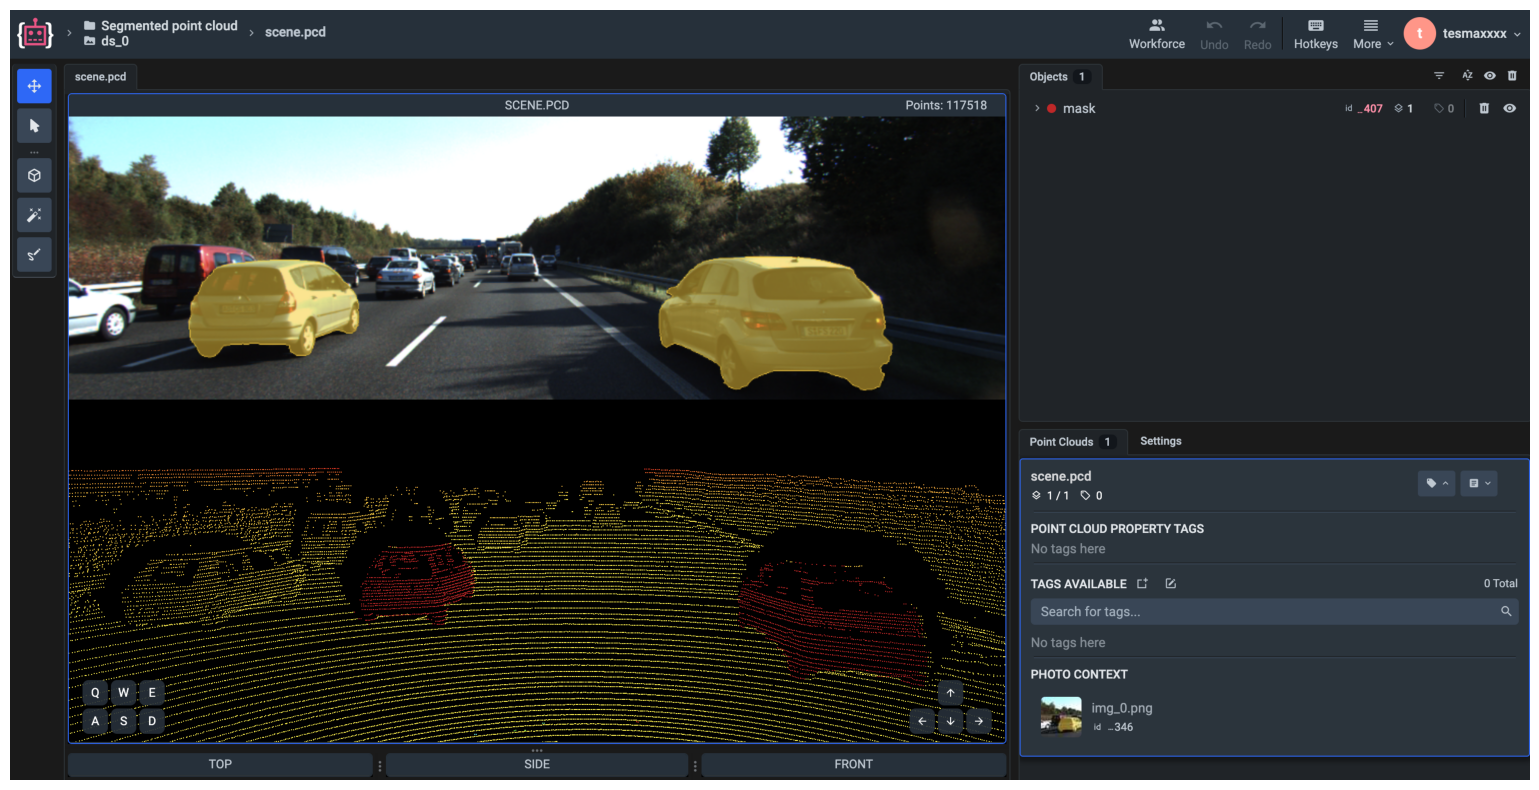

In [22]:
# screenshot from the platform
plt.axis("off")
plt.imshow(Image.open("../tutorial_data/result.png"));

### Acknowledgement

This tutorial is based on [great work](https://github.com/itberrios/CV_tracking/tree/main) by Isaac Berrios.